In [1]:
import numpy as np
import scipy.special as sysp
import sys,os

from reion_uvlf_funcs import model_and_data

sys.path.append('../../code/')
from mountaineer import Model,Chi2,Mountaineer
from paths import *

sys.path.append(ML_Path)
from mlalgos import BuildNN,Sequential

sys.path.append(Picasa_Path)
from gpr_train import GPRTrainer
from picasa import PICASA

import copy
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

from cobaya.run import run
from cobaya.log import LoggedError
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

pic = PICASA()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

## Posterior Emulation with [Mountaineer](https://github.com/a-paranjape/mountaineer)

### UVLF & Reionization Model

In [3]:
class UVLF_Reionization(Model):
    def __init__(self,n_params=9,fixed_params={}):
        # expect fixed_params to be dictionary with keys as subset of ['a0','a1',...] and values of these params
        self.fixed_params = fixed_params
        n_tot = n_params + len(self.fixed_params.keys())
        if n_tot != 9:
            raise Exception('UVLF_Reionization works with 9 params, but {0:d} specified.'.format(n_tot))
            
        self.all_params = {'a{0:d}'.format(p):0.0 for p in range(9)} # re-usable dictionary
        self.varied_params = list(self.all_params.keys())
        for par in self.fixed_params.keys():
            self.varied_params.remove(par)
        # now self.varied_params is list of names of varied parameters
        print('varied params: ',self.varied_params)
        
        Model.__init__(self,n_params=n_params)
        self.dlntheta = 1e-2*np.ones(n_params) # should be much smaller than typical step-size in each direction
        data,dum2,dum3 = model_and_data(-0.19, -0.92, 13.0, 2.1, 4.97, 0.34, -0.97, -0.41,9.32)
        self.n_data = data.size

    def calc_model(self,X):
        # lsum, ldiff, l2, l3, asum, adiff,  log10_fesc10, alpha_esc, log10Mcrit = self.params.T[0]
        # try:
        #     out,dummy1,dummy2 = model_and_data(lsum, ldiff, l2, l3, asum, adiff,  log10_fesc10, alpha_esc, log10Mcrit)
        p_this = self.params.T[0].copy()
        p = 0
        for key in self.all_params.keys():
            if key in self.varied_params:
                self.all_params[key] = p_this[p]
                p += 1
            else:
                self.all_params[key] = self.fixed_params[key]
        a0,a1,a2,a3,a4,a5,a6,a7,a8 = self.all_params.values()
        try:
            out,dummy1,dummy2 = model_and_data(a0,a1,a2,a3,a4,a5,a6,a7,a8)
        except ValueError:
            # print("Exception at parameters:",self.params.T[0])
            out = np.array([1e30]*self.n_data)
            
        self.model_fid = out.copy()
        return self.rv(out[X[0]]) # X.shape = (1,n_samp)
    
    def calc_dmdtheta(self):
        # self.X,self.model_fid will be available for the data set
        dmdtheta = np.zeros((self.n_params,self.X.shape[1])) # (n_params,n_samp)
        Dtheta = np.fabs(self.params.T[0])*self.dlntheta # Dtheta
        switcher = np.ones(self.n_params)
        u = np.random.rand(self.n_params)
        switcher[u < 0.5] = -1.0
        for p in range(self.n_params):
            params_vary = self.params.T[0].copy()
            params_vary[p] += switcher[p]*Dtheta[p] # theta +- Dtheta
            # lsum, ldiff, l2, l3, asum, adiff,  log10_fesc10, alpha_esc, log10Mcrit = params_vary
            # try:
            #     model_vary,dum1,dum2 = model_and_data(lsum, ldiff, l2, l3, asum, adiff,  log10_fesc10, alpha_esc, log10Mcrit) 
            pv = 0
            for key in self.all_params.keys():
                if key in self.varied_params:
                    self.all_params[key] = params_vary[pv]
                    pv += 1
                else:
                    self.all_params[key] = self.fixed_params[key]
            a0,a1,a2,a3,a4,a5,a6,a7,a8 = self.all_params.values()
            try:
                model_vary,dummy1,dummy2 = model_and_data(a0,a1,a2,a3,a4,a5,a6,a7,a8)
                # M(theta +- Dtheta)
            except ValueError:
                # print("Exception at parameters:",params_p)
                model_vary = np.array([1e30]*self.n_data)
            dmdtheta[p] = switcher[p]*(model_vary[self.X[0]] - self.model_fid[self.X[0]]) 
            # +- [ Model(theta +- Dtheta) - Model(theta) ]
            # = +- Model(theta +- Dtheta) -+ Model(theta)
            # ... = (+): Model(theta + Dtheta) - Model(theta)
            # ... = (-): Model(theta) - Model(theta - Dtheta)

        dmdtheta = dmdtheta.T
        dmdtheta /= (Dtheta + 1e-15)
        dmdtheta = dmdtheta.T
        
        return dmdtheta


## Setup data

In [4]:
Narrow = True

In [5]:
# rng = np.random.RandomState(1983)
pbest_cobaya = np.array([-4.8750e-01,-8.8095e-01,1.0735e+01,1.2034e+00,9.4376e-01,2.8934e-01,-8.1220e-01,-7.8249e-02,1.0174e+01])

N_Vary = 4
if N_Vary > pbest_cobaya.size:
    raise Exception('N_Vary must be less than {0:d}'.format(pbest_cobaya.size))
Fixed_Params = {'a'+str(p):pbest_cobaya[p] for p in range(N_Vary,9)}

N_evals_max = 8000 # MCMC needed 558703 total steps, 69840 accepted.
id_str = 'reion' 
survey_frac = 0.025 # 0.05

model = UVLF_Reionization(n_params=N_Vary,fixed_params=Fixed_Params)

dummy,data,sigma = model_and_data(-0.19, -0.92, 13.0, 2.1, 4.97, 0.34, -0.97, -0.41,9.32)

X_all = np.arange(data.size)
n_samp = X_all.size
X_all = model.rv(X_all)

n_params = model.n_params
cov_mat = np.diag(sigma**2)
Y_all = model.rv(data)

dof = X_all.shape[1] - n_params

id_str += '_lgNmax{0:.2f}'.format(np.log10(N_evals_max))
if Narrow:
    id_str += '_narrow'
if N_Vary < pbest_cobaya.size:
    id_str += '_np{0:d}'.format(N_Vary)

# best seems pLike_B2adam. checking 4k walks.
# id_str += '_pLike'
# id_str += '_B1sgdB2adam' # '_adam', '_sgd', '_B1adamB2sgd', '_B1sgdB2adam', '_B2adam', '_B1adam', ''

print('id_str:',id_str)
file_stem = 'walks/' + id_str

varied params:  ['a0', 'a1', 'a2', 'a3']
id_str: reion_lgNmax3.90_narrow_np4


In [6]:
Walks_Exist = False

if Narrow:
    param_mins = {'a0':-1.0,'a1':-1.5,'a2':9.5,'a3':0.5,'a4':0.0,'a5':0.0,'a6':-1.0,'a7':-0.75,'a8':8}
    param_maxs = {'a0':2.0,'a1':0.0,'a2':15.5,'a3':4.0,'a4':7.0,'a5':0.5,'a6':-0.5,'a7':0.75,'a8':11}
else:
    param_mins = {'a0':-2.0,'a1':-2.0,'a2':8.0,'a3':0.5,'a4':0.0,'a5':0.0,'a6':-3.0,'a7':-3.0,'a8':9.0}
    param_maxs = {'a0': 2.0,'a1': 1.0,'a2':18.0,'a3':6.0,'a4':7.0,'a5':1.0,'a6':1.0,'a7':1.0,'a8':11.0}

for key in Fixed_Params.keys():
    del param_mins[key]
    del param_maxs[key]

loss_params = {'cov_mat':cov_mat}

dp = {'N_evals_max':N_evals_max,'survey_frac':survey_frac,'file_stem':file_stem,'model':UVLF_Reionization,'n_params':n_params,
      'param_mins':list(param_mins.values()),'param_maxs':list(param_maxs.values()),
      'X':X_all,'Y':Y_all,'val_frac':0.2,'loss':Chi2,'walks_exist':Walks_Exist,
      'seed':None,'verbose':True,'logfile':None,'loss_params':loss_params}

mnt = Mountaineer(data_pack=dp,fixed_params=Fixed_Params)

varied params:  ['a0', 'a1', 'a2', 'a3']
Mountaineer to explore loss land-scape!
... initialization done


In [7]:
# start_time = time()
# Xp_ev = mnt.rv(pbest_cobaya)
# Yp_ev = np.zeros((1,1))
# loss_params_ev = copy.deepcopy(loss_params)
# loss_params_ev['Y_full'] = mnt.Y
# for n in range(1):
#     model.params[:,0] = Xp_ev[n]
#     Loss_ev = mnt.loss_module(loss_params_ev)
#     Yp_ev[0,n] = Loss_ev.forward(model.calc_model(mnt.X))
#     mnt.status_bar(n,Nsamp_ev)
# Xp_ev = Xp_ev.T
# mnt.time_this(start_time)
# print(Xp_ev,Yp_ev)

Surveying using 200 locations 5 times...
... iteration 1
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 200 of 200 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 9; breaking.
... ... adjusting parameter ranges
... iteration 2
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 200 of 200 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 15; breaking.
... ... adjusting parameter ranges
... iteration 3
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 200 of 200 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 27; breaking.
... ... adjusting paramete

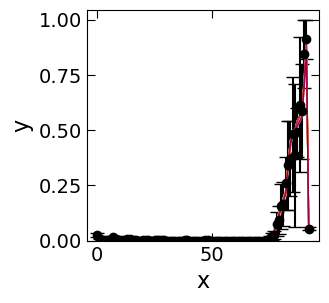

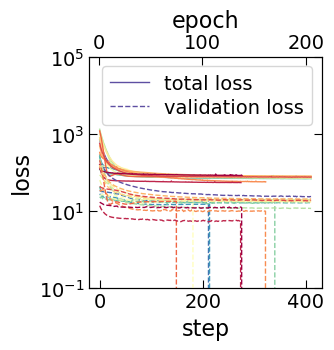

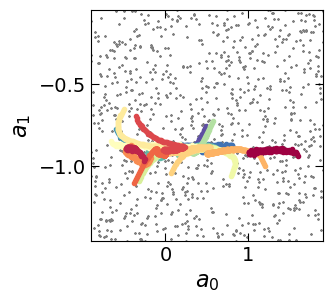

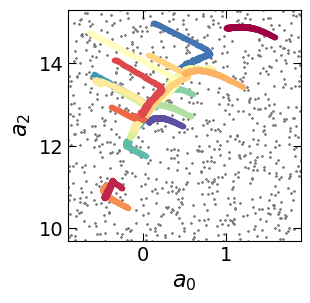

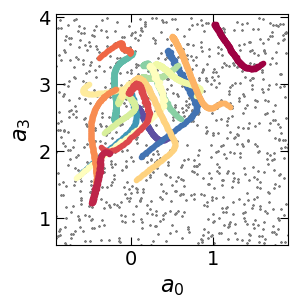

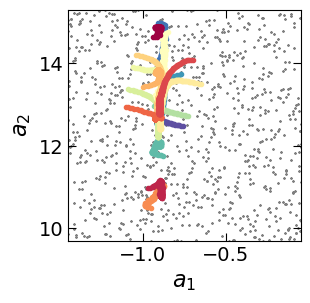

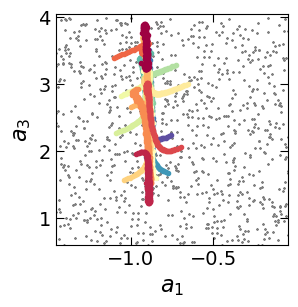

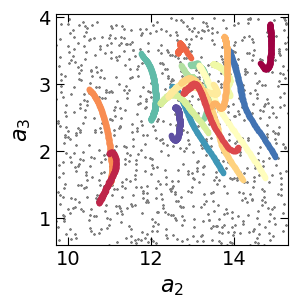

Reading from file: walks/reion_lgNmax3.90_narrow_np4_all.txt


In [8]:
start_time = time()
walks = mnt.explore()
mnt.time_this(start_time)
mnt.visualize(walks)
data = mnt.load()

In [9]:
Nevals_mnt = mnt.N_evals_model + mnt.N_evals_deriv*mnt.n_params
ibest_mnt = np.argmin(data[0])
chi2_best_mnt = data[0,ibest_mnt]
pbest_mnt = data[1:,ibest_mnt].copy()  

model.params = mnt.cv(pbest_mnt)
model_best_mnt = model.forward(mnt.X)[0]

print(Nevals_mnt)
print(chi2_best_mnt)
print(pbest_mnt)
print(pbest_cobaya)

41807
53.32419
[-0.4688879 -0.8862349 10.73964    1.231342 ]
[-0.4875   -0.88095  10.735     1.2034    0.94376   0.28934  -0.8122
 -0.078249 10.174   ]


## Emulation

### GPR

In [10]:
GPR_Exists = Walks_Exist
CV_Thresh = 1e-3 
GPR_Dir = 'gpr/stats_'+id_str
gprt = GPRTrainer(data_file=mnt.walks_file,tmp_dir=GPR_Dir)

In [11]:
start_time = time()
Kernel = 'matern' 
Max_Iter = 25 
if GPR_Exists:
    interpolator = gprt.train_gpr(verbose=True,vary_kernel=False,kernel=Kernel,skip_train=True)
else:
    interpolator = gprt.train_gpr(cv_thresh=CV_Thresh,verbose=True,vary_kernel=True,max_iter=Max_Iter,max_iter_vary=Max_Iter//5)
gprt.time_this(start_time)


Varying kernels to find best option
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.

Kernel rq is best choice: cv(1pc,99pc) after 5 iters = (-1.17e+00,3.65e+00)


... training with 333 of 6677 samples
... ... current conv_stat = 1.00e+00; waiting for 1.00e-03
... setting up Gaussian Process Regression
... ... using Rational Quadratic kernel
... ... starting with (norm,alpha,scale) = (1.000,1.000,1.000)
... ... fitting GP on training set (333 values; ~5% of input data)
0 min 0.80 seconds

... ... setting up Cholesky decomposition
... ... log-marg-like = 1683.09
... ... best kernel params = (3.658,0.698,0.940)
6.23**2 * RationalQuadratic(alpha=2.01, length_scale=2.56)
... ... writing best kernel params to file: gpr/stats_reion_lgNmax3.90_narrow_np4/hyper.tmp
... ... cross-validating
... ... (1,16,50,84,99) percentiles of rel

### Neural network

In [12]:
Xp = data[1:,:]
Yp = mnt.rv(data[0])
print(Xp.shape,Yp.shape,mnt.n_params)

# trim
print('Trimming training data...')
keep_these = np.ones(Yp.shape[1],dtype=bool)
for p in range(Xp.shape[0]):
    keep_these = keep_these & (Xp[p] >= mnt.param_mins[p]) & (Xp[p] <= mnt.param_maxs[p])
print('... keeping {0:d} of {1:d}'.format(np.where(keep_these)[0].size,keep_these.size))

Xp = Xp[:,keep_these]
Yp = Yp[:,keep_these]
print(Xp.shape,Yp.shape,mnt.n_params)

(4, 6677) (1, 6677) 4
Trimming training data...
... keeping 6227 of 6677
(4, 6227) (1, 6227) 4


In [ ]:
Build = not Walks_Exist

Train_Frac = 0.8 
Val_Frac = 0.2
Arch_Type = 'emulator:deep'
Min_Layer = 2
Max_Layer = 4
Max_Ex = [n_params,2*n_params,4*n_params]#[2*n_params,3*n_params]#,4*n_params] 
LRates = [3e-4,1e-3] # [3e-4] # None or list of floats
Wt_Decays = [0.1] # non-empty list
N_Iter = 20
TTL = 1e-3
Loss_Type = 'square'
Seed = None
FileStem = 'net/NN_'+id_str

start_time = time()
bnn = BuildNN(Xp,Yp,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,thresholds=None,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,
              target_test_stat=TTL,loss_type=Loss_Type,seed=Seed,file_stem=FileStem)
if Build:
    net,params_train,mtl = bnn.trainNN()
    print('Best mean test loss = {0:.3e}'.format(mtl))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train = bnn.load_train()
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
bnn.time_this(start_time)

Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 6227 samples
... fraction 0.800 (4982 samples) will be used for training
... setting up training and test samples
... setup complete
Initiating search... 
... cycling over 20 repetitions of 36 possible options
[.......             ] 36% done

In [ ]:
if Build:#Train:
    plt.figure(figsize=(4,4))
    plt.xlim(0.5,2*params_train['max_epoch'])
    # plt.ylim(1e-4,1e7)
    plt.yscale('log')
    plt.xscale('log')
    nn_label = '{0:1d}-layer NN'.format(net.L)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(net.epochs,net.epoch_loss,'k-',lw=0.5,label=nn_label+': train')
    plt.plot(net.epochs,net.val_loss,'r-',lw=0.5,label=nn_label+': val')
    plt.legend()
    plt.show()
    print(net.epoch_loss[-1])

### Testing emulators

In [ ]:
print('True loss calculation')
start_time = time()
# Nsamp_ev = 1000
# Xp_ev = mnt.gen_latin_hypercube(Nsamp=Nsamp_ev,dim=mnt.n_params,param_mins=mnt.param_mins,param_maxs=mnt.param_maxs)
# Yp_ev = np.zeros((1,Nsamp_ev))
# loss_params_ev = copy.deepcopy(loss_params)
# loss_params_ev['Y_full'] = mnt.Y
# for n in range(Nsamp_ev):
#     model.params[:,0] = Xp_ev[n]
#     Loss_ev = mnt.loss_module(loss_params_ev)
#     Yp_ev[0,n] = Loss_ev.forward(model.calc_model(mnt.X))
#     mnt.status_bar(n,Nsamp_ev)
# Xp_ev = Xp_ev.T
mnt.time_this(start_time)

print('NN prediction for loss')
start_time = time()
Yp_ev_pred_nn = net.predict(Xp_ev)
mnt.time_this(start_time)

resid_nn = Yp_ev_pred_nn[0]/Yp_ev[0] - 1

print('GPR prediction for loss')
start_time = time()
Yp_ev_pred_gpr = gprt.predict(Xp_ev.T,interpolator)
mnt.time_this(start_time)

resid_gpr = Yp_ev_pred_gpr/Yp_ev[0] - 1

In [ ]:
plt.xscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted / true - 1')
plt.ylim(-1,1)
plt.scatter(Yp_ev[0],resid_nn,s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],resid_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted loss')
plt.plot(np.logspace(2.0,6.5,10),np.logspace(2.0,6.5,10),'k--',lw=1)
plt.scatter(Yp_ev[0],Yp_ev_pred_nn[0],s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],Yp_ev_pred_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

## MCMC

In [ ]:
Like_Dir = '../../code/likes/'
Plots_Dir = 'plots/'

Run_Cobaya = False
Run_NN = True
Run_GPR = False

Max_Samples = 1000000
Rminus1_Stop = 0.01
Rminus1_CL_Stop = 0.05 # 0.05
Rminus1_CL_Level = 0.95 # 95

Burn_In = 0

gd_sample = loadMCSamples(os.path.abspath('cobaya_chains/chains/reion_uvlf_9p'))
Latex_List = gd_sample.paramNames.labels()[:mnt.n_params]
Params_List = gd_sample.paramNames.list()[:mnt.n_params]
# Latex_List = ["a_{{{0:d}}}".format(p) for p in range(n_params)]
# Params_List = ["a{0:d}".format(p) for p in range(n_params)]

info = {}
info['params'] = {}
for p in range(len(Params_List)):
    ref = pbest_mnt[p] 
    info['params'][Params_List[p]] = {'ref':{'min':ref-0.005,'max':ref+0.005},
                                      'prior':{'min':mnt.param_mins[p],'max':mnt.param_maxs[p]},
                                      'proposal':0.005,'latex':Latex_List[p]}

info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 10000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}
info_output = 'stats/chains/'+id_str
info['output'] = info_output
info["force"] = True    

if Run_NN:
    info_nn = copy.deepcopy(info)
    info_nn['likelihood'] = {'likelihoods.EmulLike':
                             {'python_path':Like_Dir}}
    info_nn['theory'] = {'likelihoods.NNTheory':
                             {'python_path':Like_Dir,
                              'net':net,'keys':Params_List}}
    info_nn['output'] = info_output+'_nn'

if Run_GPR:
    info_gpr = copy.deepcopy(info)
    info_gpr['likelihood'] = {'likelihoods.EmulLike':
                                 {'python_path':Like_Dir}}
    info_gpr['theory'] = {'likelihoods.GPRTheory':
                             {'python_path':Like_Dir,
                              'gprt':gprt,'interpolator':interpolator,'keys':Params_List}}
    info_gpr['output'] = info_output+'_gpr'


In [ ]:
if Run_Cobaya:
    start_time = time()
    updated_info, sampler = run(info)
    Neval_cobaya = pic.calc_Neval(sampler)
    print('Neval_cobaya = {0:d}'.format(Neval_cobaya))
    mnt.time_this(start_time)
else:
    Neval_cobaya = 558703
    print('Chains (hopefully) exist!')

In [ ]:
if Run_NN:
    start_time = time()
    updated_info_nn, sampler_nn = run(info_nn)
    Neval_nn = pic.calc_Neval(sampler_nn)
    print('Neval_nn = {0:d}'.format(Neval_nn))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

In [ ]:
if Run_GPR:
    start_time = time()
    updated_info_gpr, sampler_gpr = run(info_gpr)
    Neval_gpr = pic.calc_Neval(sampler_gpr)
    print('Neval_gpr = {0:d}'.format(Neval_gpr))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

In [ ]:
Save_Fig = False

Show_MCMC = False
Show_NN = True
Show_GPR = True

In [ ]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
dim = n_params

start_time = time()

if Show_MCMC:
    gd_sample = loadMCSamples(os.path.abspath('cobaya_chains/chains/reion_uvlf_9p'),settings={'ignore_rows':Burn_Frac})
    gd_sample.label = 'MCMC: {0:d} evals'.format(Neval_cobaya) 
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    sample = gd_sample.samples
    sample = sample.T
    ibest = sample[-2].argmin()
    mcmc_best = sample[:dim,ibest]
    mcmc_chi2 = sample[-2,ibest]
    pval = sysp.gammainc(mcmc_chi2/2,dof/2)
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    print('MCMC...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2,dof,mcmc_chi2/dof,pval))

if Show_NN:
    gd_sample_nn = loadMCSamples(os.path.abspath(info_nn["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_nn.label = '     NN: {0:d} of {1:d} evals'.format(Xp.shape[1],Nevals_mnt)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_nn = gd_sample_nn.getCovMat().matrix[:dim, :dim]
    sample_nn = gd_sample_nn.samples
    sample_nn = sample_nn.T
    ibest_nn = sample_nn[-2].argmin()
    mcmc_best_nn = sample_nn[:dim,ibest_nn]
    mcmc_chi2_nn = sample_nn[-2,ibest_nn]
    pval_nn = sysp.gammainc(mcmc_chi2_nn/2,dof/2)
    mcmc_sig_nn = np.sqrt(np.diag(mcmc_covmat_nn))
    print('NN...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best_nn])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_nn])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_nn,dof,mcmc_chi2_nn/dof,pval_nn))

if Show_GPR:
    gd_sample_gpr = loadMCSamples(os.path.abspath(info_gpr["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_gpr.label = '   GPR: {0:d} of {1:d} evals'.format(gprt.pred_var.size,Nevals_mnt)
    # gd_sample_gpr.label = '   GPR: {0:d} evals'.format(Nevals_mnt)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_gpr = gd_sample_gpr.getCovMat().matrix[:dim, :dim]
    sample_gpr = gd_sample_gpr.samples
    sample_gpr = sample_gpr.T
    ibest_gpr = sample_gpr[-2].argmin()
    mcmc_best_gpr = sample_gpr[:dim,ibest_gpr]
    mcmc_chi2_gpr = sample_gpr[-2,ibest_gpr]
    pval_gpr = sysp.gammainc(mcmc_chi2_gpr/2,dof/2)
    mcmc_sig_gpr = np.sqrt(np.diag(mcmc_covmat_gpr))
    print('GPR...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best_gpr])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_gpr])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_gpr,dof,mcmc_chi2_gpr/dof,pval_gpr))

plot_param_list = Params_List
Subplot_Size = 1.6 

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS3

show_list = []
fill_list = []
col_list = []
if Show_MCMC:
    show_list.append(gd_sample)
    fill_list.append(True)
    col_list.append('indigo')
    # gdplot.triangle_plot(gd_sample,gd_sample.paramNames.list()[:dim],contour_colors=['indigo'],legend_loc='upper right',title_limit=0)
if Show_NN:
    show_list.append(gd_sample_nn)
    fill_list.append(True)
    col_list.append('crimson')
if Show_GPR:
    show_list.append(gd_sample_gpr)
    fill_list.append(True)
    col_list.append('darkgreen')
gdplot.triangle_plot(show_list, plot_param_list,filled=fill_list,
                     contour_colors=col_list,legend_loc='upper right',
                     title_limit=0)
for par_y in range(dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    if Show_MCMC:
        ax.axvline(mcmc_best[par_y],c='indigo',ls='--',lw=1,alpha=0.6)
    if Show_NN:
        ax.axvline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
    if Show_GPR:
        ax.axvline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        #print(par_x,par_y,':',str_x,str_y)
        ax = gdplot.subplots[par_y,par_x]
        if Show_MCMC:
            ax.scatter([mcmc_best[par_x]],[mcmc_best[par_y]],marker='*',s=50,c='aliceblue')
            ax.axvline(mcmc_best[par_x],c='indigo',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best[par_y],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if Show_NN:
            ax.scatter([mcmc_best_nn[par_x]],[mcmc_best_nn[par_y]],marker='*',s=50,c='peachpuff')
            ax.axvline(mcmc_best_nn[par_x],c='crimson',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
        if Show_GPR:
            ax.scatter([mcmc_best_gpr[par_x]],[mcmc_best_gpr[par_y]],marker='*',s=50,c='lightcyan')
            ax.axvline(mcmc_best_gpr[par_x],c='darkgreen',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)

if Save_Fig:
    filename = 'contours_'+id_str+'.png'
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)

mnt.time_this(start_time)

In [ ]:
start_time = time()
N_BOOT = 300
# MCMC
if Show_MCMC:
    model.params = mnt.cv(mcmc_best[:dim])
    model_best = model.forward(mnt.X)[0]
    
    N_Boot_Cobaya = np.min([N_BOOT,int(0.2*sample[0].size)])
    Ind = gd_sample.random_single_samples_indices(random_state=42,max_samples=N_Boot_Cobaya)
    N_Boot_Cobaya = Ind.size
    print('N_Boot_Cobaya: ',N_Boot_Cobaya)
    
    model_boot = np.zeros((N_Boot_Cobaya,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_Cobaya):
        params_b = sample[:dim,Ind[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_Cobaya)
    
    model_16pc = np.percentile(model_boot,16,axis=0)
    model_84pc = np.percentile(model_boot,84,axis=0)

    del model_boot
    gc.collect()

# NN
if Show_NN:
    model.params = mnt.cv(mcmc_best_nn[:dim])
    model_best_nn = model.forward(mnt.X)[0]
    
    N_Boot_NN = np.min([N_BOOT,int(0.2*sample_nn[0].size)])
    Ind_nn = gd_sample_nn.random_single_samples_indices(random_state=42,max_samples=N_Boot_NN)
    N_Boot_NN = Ind_nn.size
    print('N_Boot_NN: ',N_Boot_NN)
    
    model_boot_nn = np.zeros((N_Boot_NN,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_NN):
        params_b = sample_nn[:dim,Ind_nn[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot_nn[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_NN)
    
    model_16pc_nn = np.percentile(model_boot_nn,16,axis=0)
    model_84pc_nn = np.percentile(model_boot_nn,84,axis=0)

    del model_boot_nn
    gc.collect()

# GPR
if Show_GPR:
    model.params = mnt.cv(mcmc_best_gpr[:dim])
    model_best_gpr = model.forward(mnt.X)[0]
    
    N_Boot_GPR = np.min([N_BOOT,int(0.2*sample_gpr[0].size)])
    Ind_gpr = gd_sample_gpr.random_single_samples_indices(random_state=42,max_samples=N_Boot_GPR)
    N_Boot_GPR = Ind_gpr.size
    print('N_Boot_GPR: ',N_Boot_GPR)
    
    model_boot_gpr = np.zeros((N_Boot_GPR,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_GPR):
        params_b = sample_gpr[:dim,Ind_gpr[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot_gpr[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_GPR)
    
    model_16pc_gpr = np.percentile(model_boot_gpr,16,axis=0)
    model_84pc_gpr = np.percentile(model_boot_gpr,84,axis=0)

    del model_boot_gpr
    gc.collect()

cols = ['indigo','crimson','darkgreen']
plt.figure(figsize=(7,7))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(1e-7,10)
plt.yscale('log')

plt.plot(mnt.X[0],model_best_mnt,'-',lw=1,c='k',label='Mountaineer')

if Show_MCMC:
    plt.plot(mnt.X[0],model_best,'-',lw=1,c=cols[0],label='MCMC')
    plt.fill_between(mnt.X[0],model_84pc,model_16pc,color=cols[0],alpha=0.15)
if Show_NN:
    plt.plot(mnt.X[0],model_best_nn,'-',lw=1,c=cols[1],label='NN')
    plt.fill_between(mnt.X[0],model_84pc_nn,model_16pc_nn,color=cols[1],alpha=0.15)
if Show_GPR:
    plt.plot(mnt.X[0],model_best_gpr,'-',lw=1,c=cols[2],label='GPR')
    plt.fill_between(mnt.X[0],model_84pc_gpr,model_16pc_gpr,color=cols[2],alpha=0.15)

plt.errorbar(mnt.X[0],mnt.Y[0],yerr=sigma,c='k',ls='none',capsize=5,marker='o',markersize=4,label='data')

plt.legend(loc='upper left')
plt.minorticks_on()
if Save_Fig:
    filename = Plots_Dir+'stats_'+id_str+'.png'
    print('Writing to file: '+filename)
    plt.savefig(filename,bbox_inches='tight')
plt.show()

mnt.time_this(start_time)

In [ ]:
model_best_nn[-1],mnt.Y[0][-1],sigma[-1]

In [ ]:
# Train = False if Narrow else True
# FileStem = 'net/NN_'+id_str
# Seed = None #if Model_Type == 'ps' else 42

# # N_L = 12+1 # 4,8,12,16,20
# # Delta = 7
# # HLay = [n_params + Delta]*(N_L - 1)
# #########
# # * = narrow, & = full
# N_L = 3 if Narrow else 3 # 2,3*&,4
# Fac = 70 if Narrow else 90 # 30,50,70*,90&,120
# HLay = [Fac*n_params]*(N_L - 1)
# HType = 'tanh' if Narrow else 'tanh' # 'tanh'*&, 'relu'
# Wt_Decay = 0.0 # 0.0*&,0.3
# LRate = 1e-5 if Narrow else 1e-5 # 1e-5*&,1e-4
# Max_Epoch = 100000#0
# Check_After = 300 if Narrow else 100 # 300*,100&? 
# Reg_Fun = 'none' 

# params_setup = {'data_dim':Xp.shape[0],'L':N_L,'n_layer':HLay+[1],'seed':Seed,'standardize':True,
#                 'reg_fun':Reg_Fun,'wt_decay':Wt_Decay,
#                 'atypes':[HType]*(N_L-1)+['lin'],'loss_type':'square','file_stem':FileStem}
# params_train = {'lrate':LRate,'max_epoch':Max_Epoch,'mb_count':int(np.sqrt(0.8*Xp.shape[1])),'check_after':Check_After}
#                 #,'val_frac':Val_Frac}    
# net = Sequential(params_setup)
# if Train:
#     start_time = time()
#     net.train(Xp,Yp,params_train)
#     net.save()
#     print('... trained network with setup params: ',net.params)
#     net.time_this(start_time)
# else:
#     net.load()
#     print('Loaded network with setup params: ',net.params)
# print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
# print ('... done')